In [3]:
# 函数读取nrrd 返回一组2d slice
import SimpleITK as sitk
import numpy as np

def extract_relevant_slices(image_path, mask_path, axis=2):

    image = sitk.ReadImage(image_path)
    mask = sitk.ReadImage(mask_path)

    image_data = sitk.GetArrayFromImage(image)
    mask_data = sitk.GetArrayFromImage(mask)

    relevant_slices = []

    for i in range(image_data.shape[axis]):
        if axis == 0:
            slice_image = image_data[i, :, :]
            slice_mask = mask_data[i, :, :]
        elif axis == 1:
            slice_image = image_data[:, i, :]
            slice_mask = mask_data[:, i, :]
        else:
            slice_image = image_data[:, :, i]
            slice_mask = mask_data[:, :, i]

        if np.any(slice_mask == 1):
            relevant_slices.append(slice_image)

    print(f"Total 2D slices: {image_data.shape[axis]}")
    print(f"Total 2D slices with mask: {len(relevant_slices)}")

    return relevant_slices

In [4]:
# 对一张图片进行测试
image_path = 'DATA_100.nrrd'
mask_path = 'MASK_000.nrrd'
slices = extract_relevant_slices(image_path, mask_path)

Total 3D slices: 865
Total 2D slices with mask value 1: 115


In [6]:
# 读取一张nrrd 返回rgb
import SimpleITK as sitk
import numpy as np

def extract_and_combine_slices(image_path, mask_path, axis=2):

    image = sitk.ReadImage(image_path)
    mask = sitk.ReadImage(mask_path)

    image_data = sitk.GetArrayFromImage(image)
    mask_data = sitk.GetArrayFromImage(mask)

    relevant_slices = []

    for i in range(image_data.shape[axis]):
        if axis == 0:
            slice_image = image_data[i, :, :]
            slice_mask = mask_data[i, :, :]
        elif axis == 1:
            slice_image = image_data[:, i, :]
            slice_mask = mask_data[:, i, :]
        else:
            slice_image = image_data[:, :, i]
            slice_mask = mask_data[:, :, i]

        if np.any(slice_mask == 1):
            relevant_slices.append(slice_image)

    combined_rgb_images = []

    if len(relevant_slices) < 3:
        return []

    for i in range(len(relevant_slices) - 2):
        r_channel = relevant_slices[i]
        g_channel = relevant_slices[i+1]
        b_channel = relevant_slices[i+2]

        rgb_image = np.stack([r_channel, g_channel, b_channel], axis=-1)
        combined_rgb_images.append(rgb_image)

    return combined_rgb_images


In [7]:
# 对一张图片进行测试
image_path = 'DATA_100.nrrd'
mask_path = 'MASK_000.nrrd'
slices = extract_and_combine_slices(image_path, mask_path)

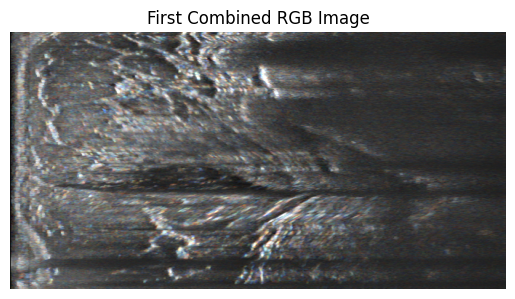

In [10]:
# 对其中一张rgb图像进行展示
import matplotlib.pyplot as plt

if slices:
    plt.imshow(slices[0])
    plt.title("First Combined RGB Image")
    plt.axis('off')
    plt.show()
else:
    print("No images to display.")


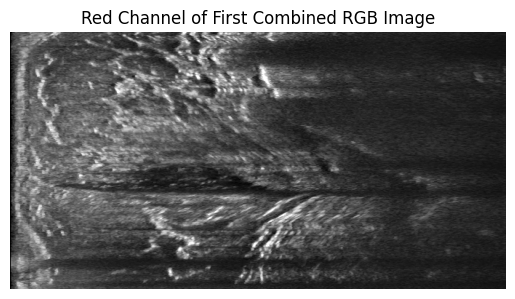

In [12]:
#提取rgb的一个维度进行比对
if slices:
    red_channel = slices[0][:, :, 0]  
    plt.imshow(red_channel, cmap='gray')  
    plt.title("Red Channel of First Combined RGB Image")
    plt.axis('off')
    plt.show()
else:
    print("No images to display.")


In [6]:
# 添加了挑选前30张图片
import SimpleITK as sitk
import numpy as np

def extract_and_combine_slices(image_path, mask_path, axis=2):

    image = sitk.ReadImage(image_path)
    mask = sitk.ReadImage(mask_path)

    image_data = sitk.GetArrayFromImage(image)
    mask_data = sitk.GetArrayFromImage(mask)

    relevant_slices = []
    mask_areas = []

    for i in range(image_data.shape[axis]):
        if axis == 0:
            slice_image = image_data[i, :, :]
            slice_mask = mask_data[i, :, :]
        elif axis == 1:
            slice_image = image_data[:, i, :]
            slice_mask = mask_data[:, i, :]
        else:
            slice_image = image_data[:, :, i]
            slice_mask = mask_data[:, :, i]

        mask_area = np.sum(slice_mask)
        if mask_area > 0:
            relevant_slices.append(slice_image)
            mask_areas.append(mask_area)

    # Get the indices of the 30 largest mask areas
    selected_indices = np.argsort(mask_areas)[-30:]

    combined_rgb_images = []

    for idx in selected_indices:
        if idx > 0 and idx < len(relevant_slices) - 1:
            r_channel = relevant_slices[idx-1]
            g_channel = relevant_slices[idx]
            b_channel = relevant_slices[idx+1]

            rgb_image = np.stack([r_channel, g_channel, b_channel], axis=-1)
            combined_rgb_images.append(rgb_image)

    return combined_rgb_images


In [2]:
# 对一张图片进行测试
image_path = 'DATA_100.nrrd'
mask_path = 'MASK_000.nrrd'
slices = extract_and_combine_slices(image_path, mask_path)

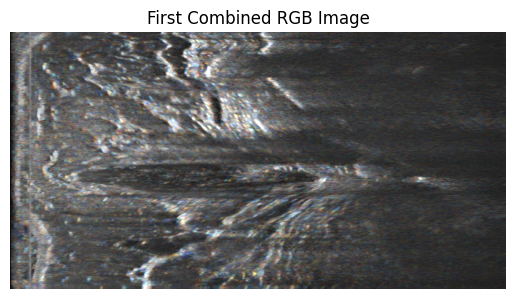

In [3]:
# 对其中一张rgb图像进行展示
import matplotlib.pyplot as plt

if slices:
    plt.imshow(slices[0])
    plt.title("First Combined RGB Image")
    plt.axis('off')
    plt.show()
else:
    print("No images to display.")

In [9]:
# 读取nrrd文件夹 以及csv 生成训练数据
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
def process_3D_images_and_save(image_folder, mask_folder, csv_file, output_base_folder):
    
    data = pd.read_csv(csv_file)
    label_mapping = dict(zip(data['case_id'], data['label']))

    output_labels = []

    output_images_folder = os.path.join(output_base_folder, 'images')
    output_csv_folder = os.path.join(output_base_folder, 'csv')

    for folder in [output_base_folder, output_images_folder, output_csv_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    image_files = sorted([f for f in os.listdir(image_folder) if f.startswith("DATA_") and f.endswith(".nrrd")])

    for image_file in image_files:
        case_num = image_file.split('_')[1].split('.')[0] 
        image_path = os.path.join(image_folder, image_file)
        mask_path = os.path.join(mask_folder, f"MASK_{case_num}.nrrd")

        combined_images = extract_and_combine_slices(image_path, mask_path)
        
        for idx, img in enumerate(combined_images):
            output_name = f"DATA_{case_num}_{idx}.png"
            plt.imsave(os.path.join(output_images_folder, output_name), img)
            label = label_mapping[int(case_num)]
            if label == 'M':
                output_labels.append(1)
            else:
                output_labels.append(0)
                
        print(f"{image_file} finished")

    output_data = pd.DataFrame({'label': output_labels})
    output_data.to_csv(os.path.join(output_csv_folder, 'output_labels.csv'), index=False)

In [10]:
# 最终测试
process_3D_images_and_save('/home/tianyu/Desktop/data_base/Init_data/DATA', 
                           '/home/tianyu/Desktop/data_base/Init_data/MASK', 
                           '/home/tianyu/Desktop/data_base/Init_data/labels.csv', 
                           '/media/tianyu/fanty/output_rgb_slices3')

DATA_000.nrrd finished
DATA_001.nrrd finished
DATA_002.nrrd finished
DATA_003.nrrd finished
DATA_004.nrrd finished
DATA_005.nrrd finished
DATA_006.nrrd finished
DATA_007.nrrd finished
DATA_008.nrrd finished
DATA_009.nrrd finished
DATA_010.nrrd finished
DATA_011.nrrd finished
DATA_012.nrrd finished
DATA_013.nrrd finished
DATA_014.nrrd finished
DATA_015.nrrd finished
DATA_016.nrrd finished
DATA_017.nrrd finished
DATA_018.nrrd finished
DATA_019.nrrd finished
DATA_020.nrrd finished
DATA_021.nrrd finished
DATA_022.nrrd finished
DATA_023.nrrd finished
DATA_024.nrrd finished
DATA_025.nrrd finished
DATA_026.nrrd finished
DATA_027.nrrd finished
DATA_028.nrrd finished
DATA_029.nrrd finished
DATA_030.nrrd finished
DATA_031.nrrd finished
DATA_032.nrrd finished
DATA_033.nrrd finished
DATA_034.nrrd finished
DATA_035.nrrd finished
DATA_036.nrrd finished
DATA_037.nrrd finished
DATA_038.nrrd finished
DATA_039.nrrd finished
DATA_040.nrrd finished
DATA_041.nrrd finished
DATA_042.nrrd finished
DATA_043.nr